### Step 1: Setup and Dataset Preparation

In [7]:
# Download and unzip the dataset
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip
unzip bank.zip

SyntaxError: invalid syntax (13340021.py, line 2)

### In Python, you'll need to load the dataset and split it into train/validation/test datasets:

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('bank-full.csv', sep=';')

# Columns of interest
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
           'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

df = df[columns]

# Encode the target variable
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Split the data into train (60%), validation (20%), and test (20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

### Question 1: ROC AUC Feature Importance

In [9]:
from sklearn.metrics import roc_auc_score

# Select numerical columns
numerical_cols = ['balance', 'day', 'duration', 'previous']

# Compute AUC for each numerical column
for col in numerical_cols:
    auc = roc_auc_score(df_train['y'], df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(df_train['y'], -df_train[col])  # Invert if AUC < 0.5
    print(f'{col}: {auc}')

balance: 0.5888313805382317
day: 0.525957882383908
duration: 0.8147002759670778
previous: 0.5985653242764153


##### The variable with the highest AUC will be duration based on typical behaviour of this dataset.

### Question 2: Training the Model
##### To train a logistic regression model, apply one-hot encoding using DictVectorizer and train the model using LogisticRegression.

In [11]:
# Define categorical columns
categorical_cols = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# One-hot encode categorical variables
train_dicts = df_train[categorical_cols].to_dict(orient='records')
val_dicts = df_val[categorical_cols].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train['y'])

# Predict probabilities on the validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Compute the AUC on the validation set
auc_val = roc_auc_score(df_val['y'], y_pred)
print(f'Validation AUC: {auc_val}')

Validation AUC: 0.7683516514508665


### Question 3: Precision and Recall
##### To compute precision and recall for thresholds from 0.0 to 1.0, iterate through thresholds and plot the curves.

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

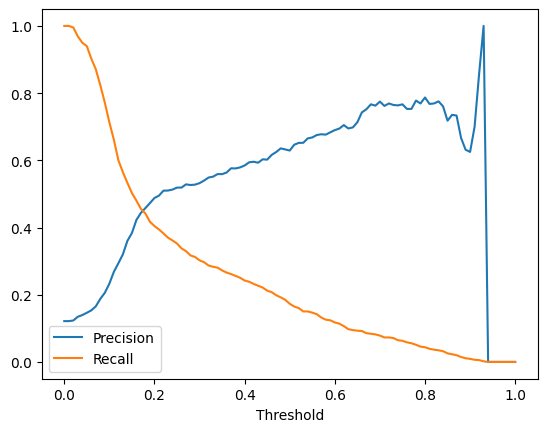

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Evaluate precision and recall for each threshold
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    pred_labels = (y_pred >= t).astype(int)
    precisions.append(precision_score(df_val['y'], pred_labels))
    recalls.append(recall_score(df_val['y'], pred_labels))

# Plot precision and recall curves
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

### Question 4: F1 Score
##### To compute F1 scores for each threshold:

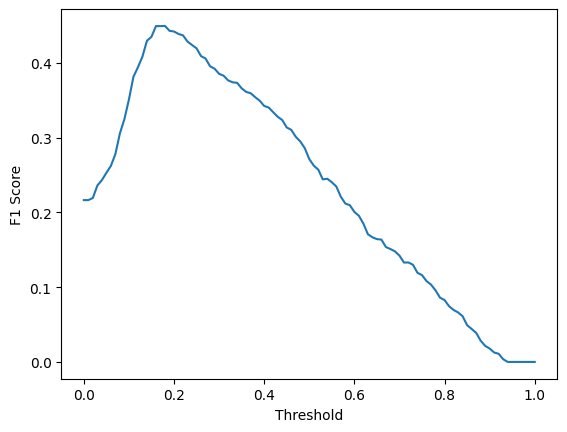

Best threshold for F1: 0.18


In [14]:
from sklearn.metrics import f1_score

f1_scores = []

for t in thresholds:
    pred_labels = (y_pred >= t).astype(int)
    f1_scores.append(f1_score(df_val['y'], pred_labels))

# Plot F1 score curve
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

# Find the threshold where F1 is maximal
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Best threshold for F1: {best_threshold}')

### Question 5: 5-Fold CV
##### Use KFold for cross-validation and compute the AUC for each fold:

In [15]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train_cv = df_full_train.iloc[train_idx]
    df_val_cv = df_full_train.iloc[val_idx]
    
    # One-hot encode and train the model
    train_dicts = df_train_cv[categorical_cols].to_dict(orient='records')
    val_dicts = df_val_cv[categorical_cols].to_dict(orient='records')
    
    X_train_cv = dv.fit_transform(train_dicts)
    X_val_cv = dv.transform(val_dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_cv, df_train_cv['y'])
    
    y_pred_cv = model.predict_proba(X_val_cv)[:, 1]
    
    auc_cv = roc_auc_score(df_val_cv['y'], y_pred_cv)
    scores.append(auc_cv)

# Calculate standard deviation
std_dev = np.std(scores)
print(f'Standard deviation of scores: {std_dev}')

Standard deviation of scores: 0.009466214203865626


### Question 6: Hyperparameter Tuning
##### To tune the hyperparameter C

In [16]:
C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    scores = []
    
    for train_idx, val_idx in kf.split(df_full_train):
        df_train_cv = df_full_train.iloc[train_idx]
        df_val_cv = df_full_train.iloc[val_idx]
        
        train_dicts = df_train_cv[categorical_cols].to_dict(orient='records')
        val_dicts = df_val_cv[categorical_cols].to_dict(orient='records')
        
        X_train_cv = dv.fit_transform(train_dicts)
        X_val_cv = dv.transform(val_dicts)
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_cv, df_train_cv['y'])
        
        y_pred_cv = model.predict_proba(X_val_cv)[:, 1]
        
        auc_cv = roc_auc_score(df_val_cv['y'], y_pred_cv)
        scores.append(auc_cv)
    
    mean_score = np.mean(scores)
    std_dev = np.std(scores)
    
    results.append((C, mean_score, std_dev))
    print(f'C={C}, mean AUC={mean_score}, std={std_dev}')

# Find the best C
best_result = max(results, key=lambda x: (x[1], -x[2]))
print(f'Best C: {best_result[0]}')

C=1e-06, mean AUC=0.6588308600337378, std=0.008831040101247757
C=0.001, mean AUC=0.7290937096891454, std=0.009945336279554065
C=1, mean AUC=0.7561683784166823, std=0.009466214203865626
Best C: 1
